In [2]:
#GPU 사용 가능한지 체크
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# !pip install boruta
# !pip install arch
# !pip install matplotlib
# !pip install seaborn
# !pip install borutapy
# !pip install joblib
#pip install tqdm
#!pip install scikeras


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [5]:
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
import attention

In [6]:
from sklearn.preprocessing import MinMaxScaler

# 전처리


In [7]:
df=pd.read_excel('./F5_데이터정리.xlsx', sheet_name='Daily')['mkt_exr']

In [8]:
#결측치 확인
df.isna().sum()

0

In [9]:
#minmaxscaler
scaler=MinMaxScaler()
df=pd.DataFrame(scaler.fit_transform(np.array(df).reshape(-1,1)))

In [10]:
#train test split
test_index=int(np.round(len(df)*0.8,0))
train_full=df[:test_index]
test=df[test_index:]
print(train_full.shape[0], test.shape[0])

4653 1163


In [11]:
#train set 다시 validation set split
val_index=int(np.round(len(train_full)*0.75,0))
train=train_full[:val_index]
valid=train_full[val_index:]
print(train.shape[0], valid.shape[0])

3490 1163


In [12]:
#data to sequence
def create_data_sequence(X, time_steps):
    input_sequence, output, times = [], [], []
    for i in range(len(X) - time_steps -1):
        sequence = X.iloc[i:(i + time_steps)].values
        input_sequence.append(sequence)
        output.append(X.iloc[i + time_steps +1]) #1일 뒤의 환율을 가져옴
        times.append(X.index[i:(i+time_steps)])
    return np.array(input_sequence), np.array(output), np.array(times)

#input: x data
#output: x sequential data
def get_seq(x_data, time_steps=100):
    x_set_sequence, x_set_output, x_times = create_data_sequence(x_data, time_steps)
    return x_set_sequence, x_set_output[:], x_times

In [13]:
#get data set
train_set_sequence, train_set_output, train_times = get_seq(train)
valid_set_sequence, valid_set_output, valid_times = get_seq(valid)
test_set_sequence, test_set_output, test_times = get_seq(test)

In [14]:
#reshape data
train_set_sequence=train_set_sequence.reshape(train_set_sequence.shape[0], train_set_sequence.shape[1], 1)
valid_set_sequence=valid_set_sequence.reshape(valid_set_sequence.shape[0], valid_set_sequence.shape[1], 1)
test_set_sequence=test_set_sequence.reshape(test_set_sequence.shape[0], test_set_sequence.shape[1], 1)

# Model 1. CNN-BiLSTM

In [15]:
#CNN-LSTM Model

def scheduler(epoch, lr):
    if epoch<10:
        return lr
    elif epoch<40:
        return lr*0.98
    elif epoch<120:
        return lr*0.95
    else:
        return lr*0.9
    

callback1=keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler)

def exr_model():
    opt = keras.optimizers.Adam(learning_rate=5e-6) #best 1e-5
    model = keras.Sequential()
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(train_set_sequence.shape[1], train_set_sequence.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(1))
    model.add(Dropout(rate=0.1))
    model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation='relu')))
    model.add(Dropout(rate=0.1))
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='relu')))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mean_squared_error', optimizer=opt)
    #model.summary()
    return model


model=exr_model()

In [16]:
#CNN-BiLSTM Fitting

model.fit(
    train_set_sequence,
    train_set_output, 
    epochs=20, 
    batch_size=64,
    validation_data=(valid_set_sequence, valid_set_output),
    callbacks=[callback1, callback2],
    shuffle=True)

print('\nFitting Complete')
#joblib.dump(model, './model1.pkl')


Epoch 1/20
53/53 [==============================] - 5s 63ms/step - loss: 0.1424 - val_loss: 0.1051 - lr: 5.0000e-06
Epoch 2/20
53/53 [==============================] - 3s 53ms/step - loss: 0.1326 - val_loss: 0.0959 - lr: 5.0000e-06
Epoch 3/20
53/53 [==============================] - 3s 49ms/step - loss: 0.1193 - val_loss: 0.0847 - lr: 5.0000e-06
Epoch 4/20
53/53 [==============================] - 3s 48ms/step - loss: 0.1030 - val_loss: 0.0712 - lr: 5.0000e-06
Epoch 5/20
53/53 [==============================] - 3s 48ms/step - loss: 0.0833 - val_loss: 0.0559 - lr: 5.0000e-06
Epoch 6/20
53/53 [==============================] - 3s 48ms/step - loss: 0.0610 - val_loss: 0.0397 - lr: 5.0000e-06
Epoch 7/20
53/53 [==============================] - 3s 49ms/step - loss: 0.0392 - val_loss: 0.0244 - lr: 5.0000e-06
Epoch 8/20
53/53 [==============================] - 3s 48ms/step - loss: 0.0218 - val_loss: 0.0135 - lr: 5.0000e-06
Epoch 9/20
53/53 [==============================] - 3s 48ms/step - loss:

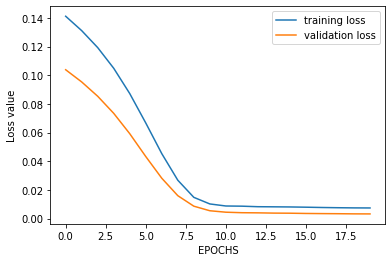

In [50]:
fig,ax = plt.subplots()
plt.plot(model.history.history['loss'], label='training loss')
plt.plot(model.history.history['val_loss'], label='validation loss')
ax.set_xlabel('EPOCHS')
ax.set_ylabel('Loss value')
#ax.set_xlim((130,200))
#ax.set_ylim((7273,7274))
ax.legend()

In [51]:
#train_predictions=model.predict(train_set_sequence)#.reshape(1,-1)[0]
test_predictions=model.predict(test_set_sequence)#.reshape(1,-1)[0]

34/34 [==============================] - 1s 25ms/step


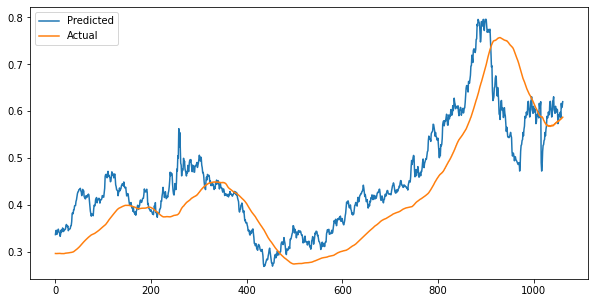

In [52]:
fig=plt.figure(figsize=(10,5))
plt.plot(test_set_output, label='actual')
plt.plot(test_predictions.reshape(-1,1), label='predicted')
plt.legend(['Predicted','Actual'])

In [ ]:
trs=train_set_output.shape[0]
tes=test_set_output.shape[0]
train=np.full((1,trs+tes), np.nan)[0]
train[:trs]=train_set_output
train[trs:]=test_set_output
test=np.full((1,trs+tes), np.nan)[0]
test[trs:]=test_predictions.reshape(1,-1)[0]

fig=plt.figure(figsize=(20,10))
plt.plot(train, label='actual')
plt.plot(test, label='predicted')

In [53]:
from sklearn.metrics import mean_squared_error

def confirm_result(y_test, y_pred, p = 14):
  
  RMSE = mean_squared_error(y_test, y_pred)**0.5
  return np.round(RMSE,4)

#print('Train RMSE: ', confirm_result(train_set_output, train_predictions.reshape(-1,1)))
print('Test RMSE: ', confirm_result(test_set_output, test_predictions.reshape(-1,1)))

Test RMSE:  0.0755


# Model 2. Seq2Seq
* Encoder: CNN
* Decoder: BiLSTM

In [54]:
#Seq2Seq
def scheduler(epoch, lr):
    if epoch<50:
        return lr
    else:
        return lr*0.95

callback1=keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler)

def exr_model():
    opt = keras.optimizers.Adam(learning_rate=1e-5) #best 1e-5
    model = keras.Sequential()
    
    #encoder
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(train_set_sequence.shape[1], train_set_sequence.shape[2])))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(RepeatVector(1))
    
    #decoder
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='relu')))
    model.add(Dropout(rate=0.1))
    model.add(Bidirectional(LSTM(units=32, return_sequences=True, activation='relu')))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mean_squared_error', optimizer=opt)
    model.summary()
    return model
model=exr_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 98, 128)           512       
                                                                 
 conv1d_6 (Conv1D)           (None, 96, 64)            24640     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 48, 64)           0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_11 (Dense)            (None, 64)                196672    
                                                                 
 repeat_vector_4 (RepeatVect  (None, 1, 64)            0         
 or)                                                  

In [55]:
#Seq2Seq Fitting

model.fit(
    train_set_sequence,
    train_set_output, 
    epochs=20, 
    batch_size=64,
    validation_data=(valid_set_sequence, valid_set_output),
    callbacks=[callback1, callback2],
    shuffle=True)

print('\nFitting Complete')
joblib.dump(model, './model2.pkl')


Epoch 1/20
53/53 [==============================] - 7s 91ms/step - loss: 0.1425 - val_loss: 0.1069 - lr: 1.0000e-05
Epoch 2/20
53/53 [==============================] - 2s 41ms/step - loss: 0.1377 - val_loss: 0.1022 - lr: 1.0000e-05
Epoch 3/20
53/53 [==============================] - 2s 38ms/step - loss: 0.1318 - val_loss: 0.0963 - lr: 1.0000e-05
Epoch 4/20
53/53 [==============================] - 2s 47ms/step - loss: 0.1234 - val_loss: 0.0878 - lr: 1.0000e-05
Epoch 5/20
53/53 [==============================] - 2s 43ms/step - loss: 0.1105 - val_loss: 0.0749 - lr: 1.0000e-05
Epoch 6/20
53/53 [==============================] - 2s 38ms/step - loss: 0.0892 - val_loss: 0.0543 - lr: 1.0000e-05
Epoch 7/20
53/53 [==============================] - 2s 44ms/step - loss: 0.0555 - val_loss: 0.0258 - lr: 1.0000e-05
Epoch 8/20
53/53 [==============================] - 2s 40ms/step - loss: 0.0199 - val_loss: 0.0054 - lr: 1.0000e-05
Epoch 9/20
53/53 [==============================] - 2s 40ms/step - loss:

INFO:tensorflow:Assets written to: ram://782b028134c6467f91ffda703901994e/assets


INFO:tensorflow:Assets written to: ram://782b028134c6467f91ffda703901994e/assets


['./model2.pkl']

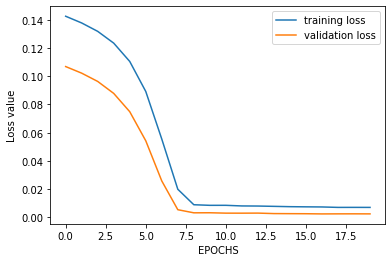

In [56]:
# Plot loss
fig,ax = plt.subplots()
plt.plot(model.history.history['loss'], label='training loss')
plt.plot(model.history.history['val_loss'], label='validation loss')
ax.set_xlabel('EPOCHS')
ax.set_ylabel('Loss value')
#ax.set_xlim((30,50))
#ax.set_ylim((4100,4200))
ax.legend()

In [57]:
#predict
#train_predictions=model.predict(train_set_sequence)
test_predictions=model.predict(test_set_sequence)#.reshape(1,-1)[0]

34/34 [==============================] - 1s 27ms/step


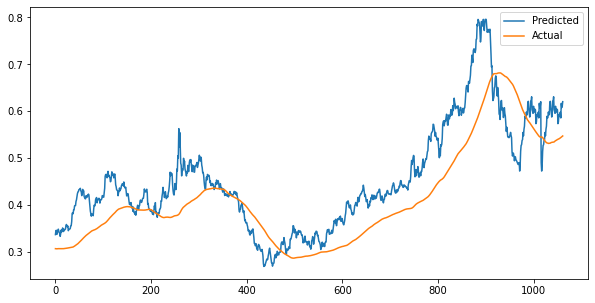

In [58]:
fig=plt.figure(figsize=(10,5))
plt.plot(test_set_output, label='actual')
plt.plot(test_predictions.reshape(-1,1), label='predicted')
plt.legend(['Predicted','Actual'])

In [ ]:
trs=train_set_output.shape[0]
tes=test_set_output.shape[0]
train=np.full((1,trs+tes), np.nan)[0]
train[:trs]=train_set_output
train[trs:]=test_set_output
test=np.full((1,trs+tes), np.nan)[0]
test[trs:]=test_predictions.reshape(1,-1)[0]

fig=plt.figure(figsize=(20,10))
plt.plot(train, label='actual')
plt.plot(test, label='predicted')
plt.legend(['Actual','Pred'])

In [59]:
from sklearn.metrics import mean_squared_error

def confirm_result(y_test, y_pred, p = 14):
  
  RMSE = mean_squared_error(y_test, y_pred)**0.5
  return np.round(RMSE,4)

#print('Train RMSE: ', confirm_result(train_set_output, train_predictions.reshape(-1,1)))
print('Test RMSE: ', confirm_result(test_set_output, test_predictions.reshape(-1,1)))

Test RMSE:  0.0715
